# Camera calibration and human body detection

## Introduction

Difficulties concern detection of human body. What might go wrong:
- confusion with jacket on the chair
- another person is behind and can be confused
- maybe lightning on image

In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, accuracy_score

In [2]:
%ls images

color_image_bonus.jpg  depth_image_colored.jpg  depth_image.png
color_image.jpg        depth_image_mask.png


Here I setup the directory

In [3]:
image_dir = os.path.join(os.getcwd(), "images")
calibration_dir  = os.path.join(os.getcwd(), "calibration")

Here I load the different images from the test

In [4]:
color_image = Image.open(os.path.join(image_dir, "color_image.jpg"))
depth_image = Image.open(os.path.join(image_dir, "depth_image.png"))
depth_image_mask = Image.open(os.path.join(image_dir, "depth_image_mask.png"))
depth_image_colored = Image.open(os.path.join(image_dir, "depth_image_colored.jpg"))

We can observe that depth_image is 3 channels

In [5]:
np.array(depth_image).shape

(1280, 720, 3)

In [6]:
%ls calibration

K_color_intrinsic.npy  K_depth_intrinsic.npy  T_color_to_depth_extrinsic.npy


I load the intrinsic and extrinsic matrices for alignment of images

In [7]:
K_color_intrinsic = np.load(os.path.join(calibration_dir, "K_color_intrinsic.npy"))
K_depth_intrinsic = np.load(os.path.join(calibration_dir, "K_depth_intrinsic.npy"))
T_color_to_depth_extrinsic = np.load(os.path.join(calibration_dir, "T_color_to_depth_extrinsic.npy"))


In [8]:
T_depth_to_color_extrinsic = np.zeros((3,4))
inv_matrix = np.linalg.inv(T_color_to_depth_extrinsic[:3,:3])
T_depth_to_color_extrinsic[:3,:3] = inv_matrix
T_depth_to_color_extrinsic[:,-1:] = np.dot(inv_matrix, T_color_to_depth_extrinsic[:,-1:])

In [9]:
color_image_ar = np.array(color_image)
depth_image_ar = np.array(depth_image)
depth_image_colored_ar = np.array(depth_image_colored)

I got this piece of code from stackoverflow [here](https://stackoverflow.com/questions/56637513/aligning-images-with-the-depth-map-in-opencv/63062563) for aligment of color and depth images, and adapt it here for our case:

In [10]:
np.unique(depth_image_ar[:,:,1])

array([ 0,  6, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
      dtype=uint8)

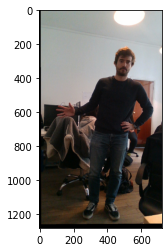

In [11]:
# All what we need to align our images:

depth_scale = 0.001

fx_d = K_depth_intrinsic[0,0]
fy_d = K_depth_intrinsic[1,1]
cx_d = K_depth_intrinsic[0,2]
cy_d = K_depth_intrinsic[1,2]

fx_rgb = K_color_intrinsic[0,0]
fy_rgb = K_color_intrinsic[1,1]
cx_rgb = K_color_intrinsic[0,2]
cy_rgb = K_color_intrinsic[1,2]

height = depth_image_ar.shape[0]
width = depth_image_ar.shape[1]

aligned = np.zeros((height,width,6))

for v in range (height):
    for u in range (width):
        # Apply Depth intrinsics
        z = 1
        x = ((u - cx_d) * z) / fx_d
        y = ((v - cy_d) * z) / fy_d
        
        # Apply extrinsic
        transformed = np.dot(T_depth_to_color_extrinsic ,np.array([x,y,z,1])).T
        aligned[v,u,0] = transformed[0]
        aligned[v,u,1] = transformed[1]
        aligned[v,u,2] = transformed[2]
        
for v in range (height):
    for u in range (width):
        # Apply RGB intrinsic
        x = (aligned[v,u,0] * fx_rgb / aligned[v,u,2]) + cx_rgb
        y = (aligned[v,u,1] * fy_rgb / aligned[v,u,2]) + cy_rgb
        
        # Endle out of bound pixels
        if x > width-1 or y > height-1 or x < 0 or y < 0:
            pass
        
        else:
            x = int(round(x))
            y = int(round(y))
        
            aligned[v,u,3] = color_image_ar[y, x, 0]
            aligned[v,u,4] = color_image_ar[y, x, 1]
            aligned[v,u,5] = color_image_ar[y, x, 2]
            
# Retrive RGB value from our aligned version
color_image_ar_aligned = np.zeros((height,width,3))
for i in range (height):
    for j in range (width):
        color_image_ar_aligned[i,j] = aligned[i,j][3:6]
plt.imshow(color_image_ar_aligned.astype(int))

In [12]:
color_image_ar_aligned.shape

(1280, 720, 3)

In [13]:
im = Image.fromarray(color_image_ar_aligned.astype('uint8'))
im.save("image_aligned.jpeg")

In the following cells, I will test different models with pixellib which is a easy to use model if you got the weights.\

First, let's try semantic segmentation with deeplab with weights [here](https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5):

In [14]:
import pixellib
from pixellib.semantic import semantic_segmentation
import time


segment_image = semantic_segmentation()

start = time.time()
segment_image.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5") 
segvalues, output = segment_image.segmentAsPascalvoc("image_aligned.jpeg", output_image_name = "image_deeplab_overlay.jpg", overlay=True)
end = time.time()
print(f"Inference Time: {end-start:.2f}seconds")

2021-10-21 22:33:09.635695: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-21 22:33:09.670788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 22:33:09.676192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-10-21 22:33:09.676206: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like t

Processed Image saved successfully in your current working directory.
Inference Time: 3.33seconds


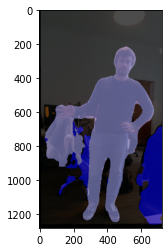

In [15]:
plt.imshow(output)

Here, we can see the jacket the right hand confuse with the jacket on the chair, and there is also with one person behind. I did not find out how to get the person class mask for evaluation with metrics. Anyway, the results seem really bad at first sight.\
Let continue with instance segmentation to get a better split, between person. For that, we can dowload model [here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjBwNzfrdzzAhWGxoUKHVuuDHcQFnoECAsQAQ&url=https%3A%2F%2Fgithub.com%2Fmatterport%2FMask_RCNN%2Freleases%2Fdownload%2Fv2.0%2Fmask_rcnn_coco.h5&usg=AOvVaw0nAUAmHpcXDQ6mPgV9NckR)

In [16]:
import pixellib
from pixellib.instance import instance_segmentation
segment_image = instance_segmentation()

segment_image.load_model("mask_rcnn_coco.h5")
start = time.time()
res = segment_image.segmentImage("image_aligned.jpeg", output_image_name = "image_coco.jpg")
end = time.time()
print(f"Inference Time: {end-start:.2f}seconds")


Instructions for updating:
Use fn_output_signature instead


/home/sylvain/modelr-notebook/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Processed image saved successfully in your current working directory.
Inference Time: 2.82seconds


In [17]:
predictions = res[0]['masks'][:,:,0]

In [18]:
jac = jaccard_score(predictions.flatten(), (np.array(depth_image_mask)[:,:,0] == 255).flatten())
acc = accuracy_score(predictions.flatten(), (np.array(depth_image_mask)[:,:,0] == 255).flatten())
print(f"IOU : {jac}, accuracy: {acc}")

IOU : 0.7923379990094548, accuracy: 0.9494997829861112


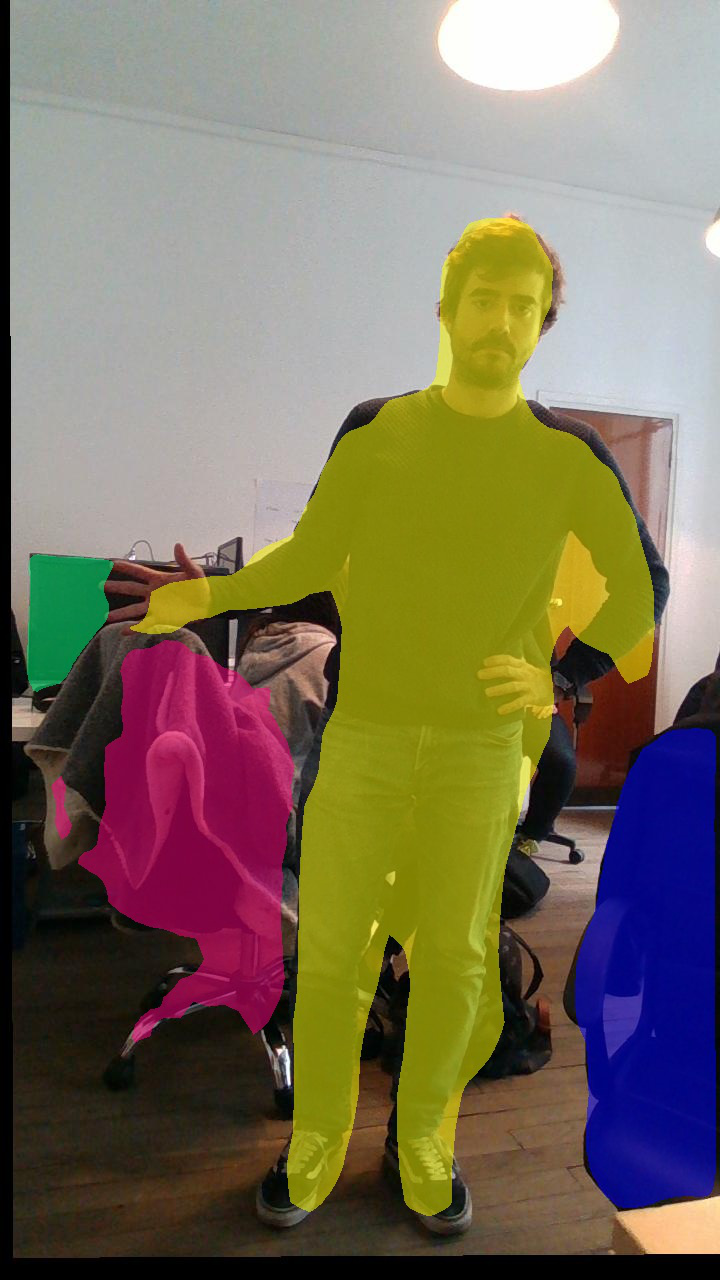

In [19]:
Image.open("image_coco.jpg")

Here, the global accuracy seem better. Contour are that well respected and there is the left arm hole filled.

In the section below, I will use "PointRend" model which is well ranked on [Paperwithcode](https://paperswithcode.com/paper/pointrend-image-segmentation-as-rendering) and available with pixellib. The weights are available [here](https://github.com/ayoolaolafenwa/PixelLib/releases/download/0.2.0/pointrend_resnet50.pkl).

In [20]:
from pixellib.torchbackend.instance import instanceSegmentation
ins = instanceSegmentation()
ins.load_model("pointrend_resnet50.pkl")
start = time.time()
res = ins.segmentImage("image_aligned.jpeg", show_bboxes=False, output_image_name="image_pointrend.jpg")
end = time.time()
print(f"Inference Time: {end-start:.2f}seconds")

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/home/sylvain/modelr-notebook/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Inference Time: 0.26seconds


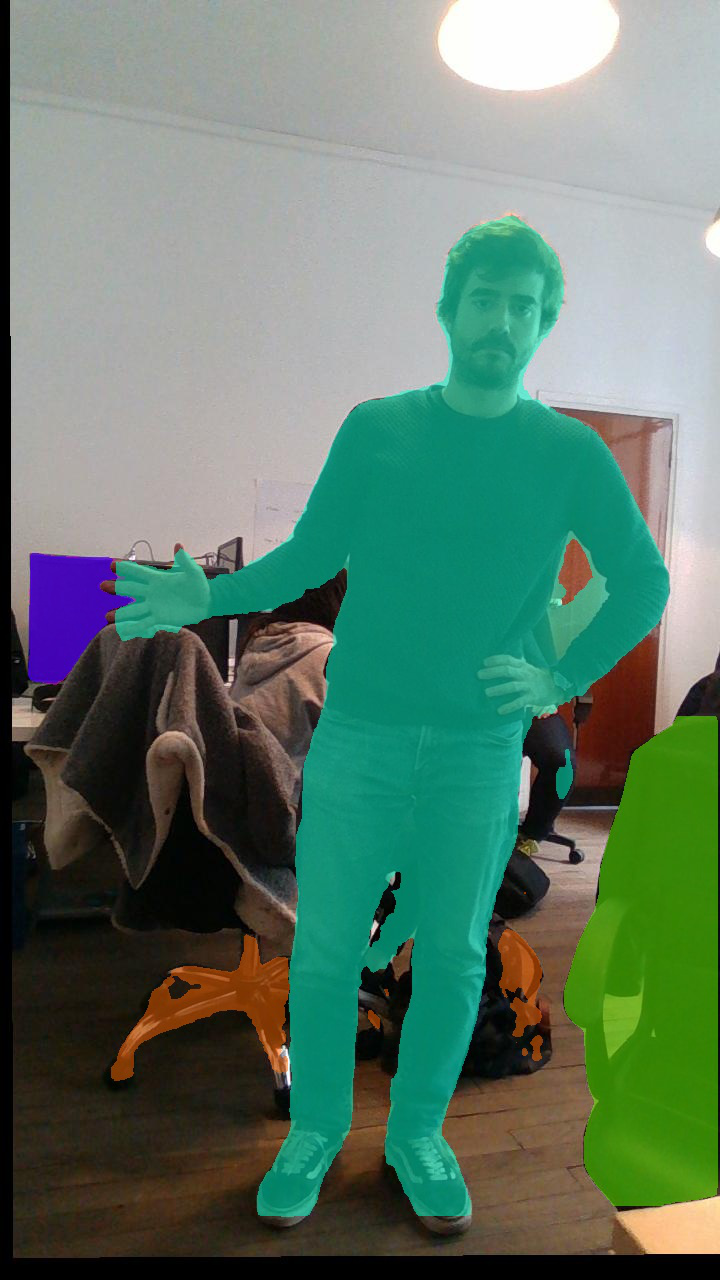

In [21]:
Image.open("image_pointrend.jpg")

Here contour of person seem really better, even on shoes. There is still a confusion the 2 persons behind. And left arm hole is not that well defined.

In [22]:
predictions = res[0]['masks'][:,:,0]

In [23]:
img_predictions = Image.fromarray(res[0]['masks'][:,:,0])

In [24]:
jac = jaccard_score(predictions.flatten(), (np.array(depth_image_mask)[:,:,0] == 255).flatten())
acc = accuracy_score(predictions.flatten(), (np.array(depth_image_mask)[:,:,0] == 255).flatten())
print(f"IOU : {jac}, accuracy: {acc}")

IOU : 0.8872736652525783, accuracy: 0.9734450954861111


# Conclusion

In term of accuracy, IOU and inference time, PointRend is really better. We could improve result by using clustering and remove the leg of one person behind.

# Apply filter on depth-map image

In [25]:
filtered_depth_image_ar_aligned = np.expand_dims(predictions, axis=2)*depth_image_colored_ar

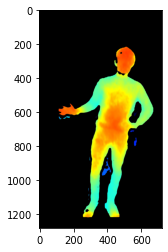

In [26]:
plt.imshow(filtered_depth_image_ar_aligned, cmap='hot')

# Bonus

In [27]:
from pixellib.torchbackend.instance import instanceSegmentation
ins = instanceSegmentation()
ins.load_model("pointrend_resnet50.pkl")
start = time.time()
res = ins.segmentImage(os.path.join(image_dir, "color_image_bonus.jpg"), show_bboxes=False, output_image_name="image_pointrend_bonus.jpg")
end = time.time()
print(f"Inference Time: {end-start:.2f}seconds")

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Inference Time: 0.18seconds


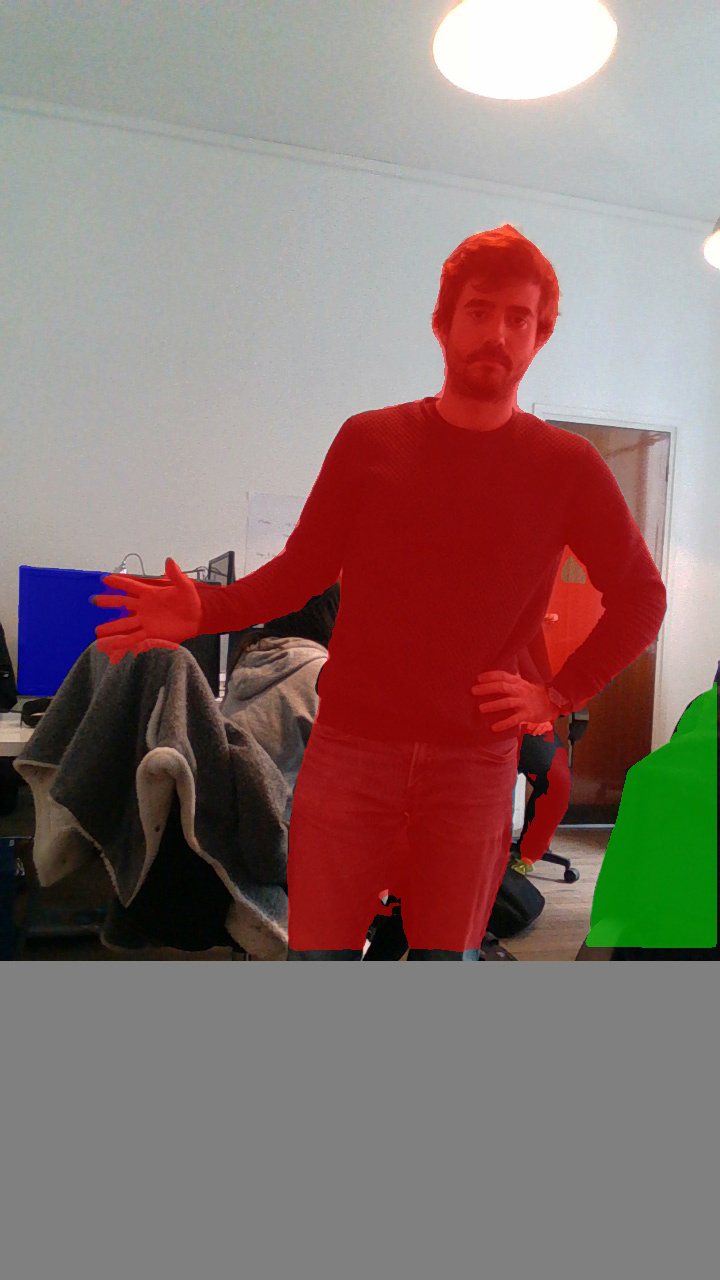

In [28]:
Image.open("image_pointrend_bonus.jpg")

Here, we can observe that the bottom of the person is not well defined. It may be due to subdivision strategy inherent to PointRend. On this case, we have a bigger artefact on the second persons behind. We may solve this issue by using clustering as previously discussed.